In [77]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from sklearn.neighbors import KNeighborsClassifier
from knn import MyKNeighborsClassifier, lowess
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn import preprocessing
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from statistics import mean
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler

# Preprocessing

In [79]:
from ucimlrepo import fetch_ucirepo

wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes) 
X = wine_quality.data.features
Y = wine_quality.data.targets['quality']


(array([  30.,  216.,    0., 2138.,    0., 2836., 1079.,    0.,  193.,
           5.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <BarContainer object of 10 artists>)

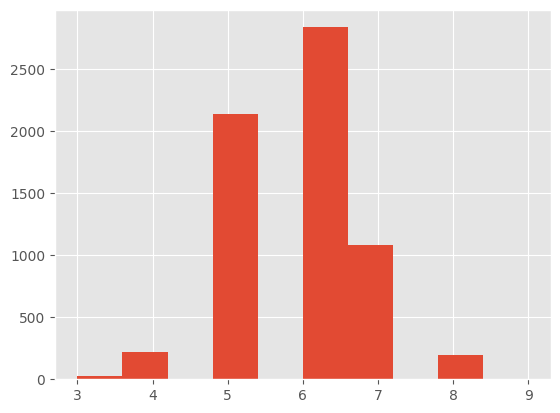

In [80]:
plt.hist(Y)

In [81]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X, Y = ros.fit_resample(X, Y)

(array([2836., 2836.,    0., 2836.,    0., 2836., 2836.,    0., 2836.,
        2836.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <BarContainer object of 10 artists>)

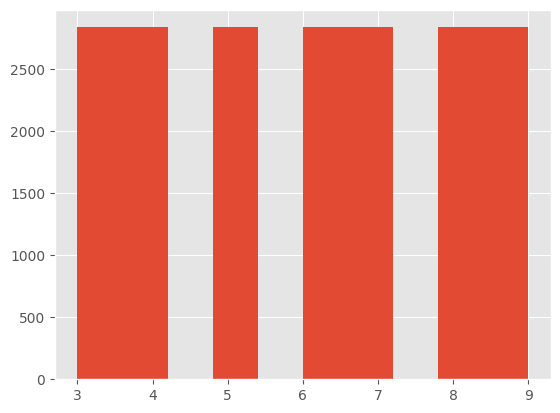

In [82]:
plt.hist(Y)


In [83]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
print(X)

[[0.29752066 0.41333333 0.         ... 0.6124031  0.19101124 0.20289855]
 [0.33057851 0.53333333 0.         ... 0.37209302 0.25842697 0.26086957]
 [0.33057851 0.45333333 0.02409639 ... 0.41860465 0.24157303 0.26086957]
 ...
 [0.25619835 0.18666667 0.20481928 ... 0.43410853 0.07865169 0.68115942]
 [0.43801653 0.12666667 0.27108434 ... 0.37209302 0.13483146 0.34782609]
 [0.29752066 0.10666667 0.21686747 ... 0.43410853 0.14606742 0.65217391]]


In [84]:
models = [KNeighborsClassifier, MyKNeighborsClassifier]
models_name = ['sklearn', 'my impl']

#  Hyperparamaters

[I 2024-04-04 14:01:23,778] A new study created in memory with name: no-name-27f222e1-87cb-491f-be3e-302fb00c416a
[I 2024-04-04 14:01:28,902] Trial 3 finished with value: 0.772986768755457 and parameters: {'n_neighbors': 8, 'metric': 'euclidean'}. Best is trial 3 with value: 0.772986768755457.
[I 2024-04-04 14:01:30,098] Trial 0 finished with value: 0.7764121163274901 and parameters: {'n_neighbors': 8, 'metric': 'manhattan'}. Best is trial 0 with value: 0.7764121163274901.
[I 2024-04-04 14:01:30,343] Trial 2 finished with value: 0.7651957821210289 and parameters: {'n_neighbors': 9, 'metric': 'manhattan'}. Best is trial 0 with value: 0.7764121163274901.
[I 2024-04-04 14:01:31,708] Trial 1 finished with value: 0.6995768688293371 and parameters: {'n_neighbors': 20, 'metric': 'manhattan'}. Best is trial 0 with value: 0.7764121163274901.
[I 2024-04-04 14:01:34,122] Trial 4 finished with value: 0.845322049835449 and parameters: {'n_neighbors': 2, 'metric': 'cosine'}. Best is trial 4 with val

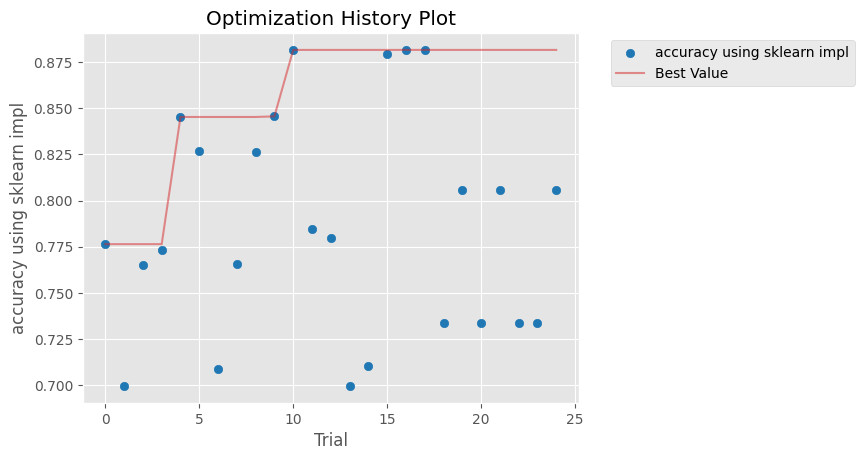

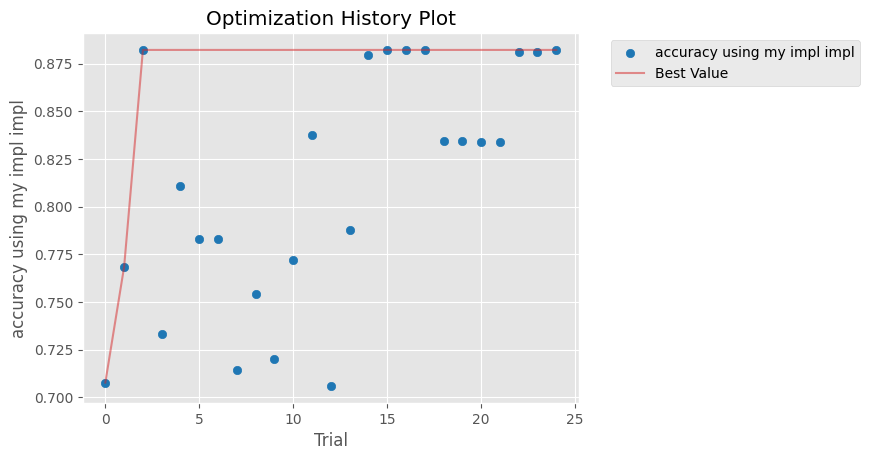

In [86]:

def train_all(trial, model):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
    n = trial.suggest_int("n_neighbors", 1, 20)
    m = trial.suggest_categorical("metric", ['euclidean', 'cosine', 'manhattan'])
    if model is MyKNeighborsClassifier:
        k = trial.suggest_categorical('kernel',
                                      ['uniform_kernel', 'gaussian_kernel', 'triungular_kernel', 'epachnikov_kernel'])
        fixed = trial.suggest_categorical('is_fixed_window', [True, False])
        window_parameter = trial.suggest_int("window_parameter", 1, n)
        clf = model(n_neighbors=n, metric=m, kernel=k, is_fixed_window=fixed, window_parameter=window_parameter)
    else:
        clf = model(n_neighbors=n, metric=m)
    clf.fit(x_train, y_train)
    return mean(cross_val_score(clf, x_train, y_train, cv=3, scoring='accuracy'))


bmods = []
for mod, name in zip(models, models_name):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: train_all(trial, mod), n_trials=25, n_jobs=5)
    plot_optimization_history(study, target_name=f'accuracy using {name}')
    bmods.append(study.best_params)


[I 2024-04-04 14:07:47,630] A new study created in memory with name: no-name-74713222-e91d-4d6a-8711-69f9003d28e6
[I 2024-04-04 14:07:48,639] Trial 0 finished with value: 0.8952916618634064 and parameters: {'n_neighbors': 1}. Best is trial 0 with value: 0.8952916618634064.
[I 2024-04-04 14:07:50,192] Trial 1 finished with value: 0.6886952419861878 and parameters: {'n_neighbors': 24}. Best is trial 0 with value: 0.8952916618634064.
[I 2024-04-04 14:07:51,595] Trial 2 finished with value: 0.7212694007538881 and parameters: {'n_neighbors': 18}. Best is trial 0 with value: 0.8952916618634064.
[I 2024-04-04 14:07:53,115] Trial 3 finished with value: 0.6866129919713551 and parameters: {'n_neighbors': 25}. Best is trial 0 with value: 0.8952916618634064.
[I 2024-04-04 14:07:54,536] Trial 4 finished with value: 0.7212694007538881 and parameters: {'n_neighbors': 18}. Best is trial 0 with value: 0.8952916618634064.
[I 2024-04-04 14:07:55,995] Trial 5 finished with value: 0.7136128721812381 and pa

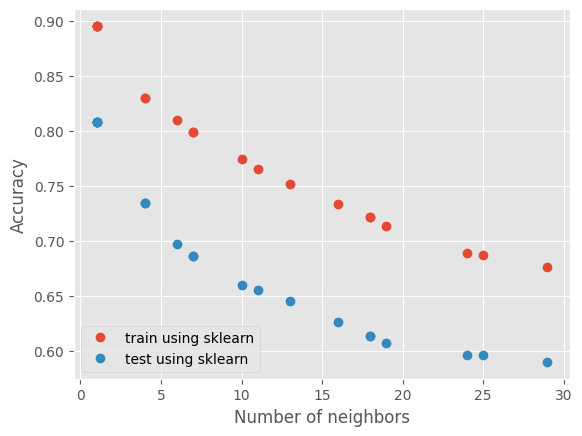

[I 2024-04-04 14:08:12,879] A new study created in memory with name: no-name-9c53dd76-4b82-463b-af08-dd92bcd81123
[I 2024-04-04 14:08:20,777] Trial 0 finished with value: 0.8051582842536005 and parameters: {'n_neighbors': 8}. Best is trial 0 with value: 0.8051582842536005.
[I 2024-04-04 14:08:30,321] Trial 1 finished with value: 0.7293968556335081 and parameters: {'n_neighbors': 18}. Best is trial 0 with value: 0.8051582842536005.
[I 2024-04-04 14:08:40,504] Trial 2 finished with value: 0.7169040774435209 and parameters: {'n_neighbors': 20}. Best is trial 0 with value: 0.8051582842536005.
[I 2024-04-04 14:08:49,055] Trial 3 finished with value: 0.8051582842536005 and parameters: {'n_neighbors': 8}. Best is trial 0 with value: 0.8051582842536005.
[I 2024-04-04 14:08:55,933] Trial 4 finished with value: 0.8949560916207151 and parameters: {'n_neighbors': 2}. Best is trial 4 with value: 0.8949560916207151.
[I 2024-04-04 14:09:05,038] Trial 5 finished with value: 0.7582769669322879 and para

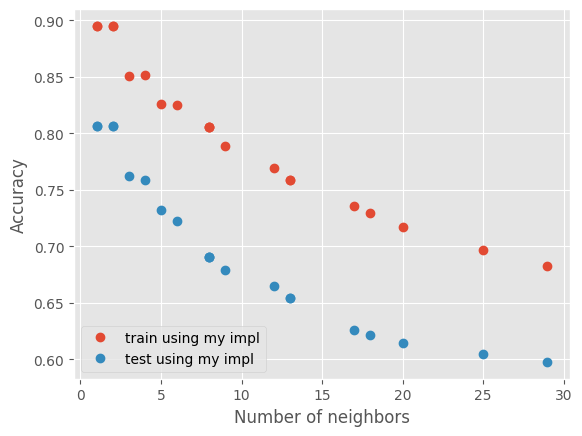

In [87]:

out = ([], [])
ind = []


def train_neighbors(trial, model):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=8)
    n = trial.suggest_int("n_neighbors", low=1, high=30)
    ind.append(n)
    clf = model(n_neighbors=n, metric="minkowski")
    clf.fit(x_train, y_train)
    res = mean(cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy'))
    out[0].append(res)
    out[1].append(mean(cross_val_score(clf, x_test, y_test, cv=5, scoring='accuracy')))
    return res


for mod, name in zip(models, models_name):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: train_neighbors(trial, mod), n_trials=20)
    plt.plot(ind, out[0], 'o', label=f'train using {name}')
    plt.plot(ind, out[1], 'o', label=f'test using {name}')
    plt.legend(loc="lower left")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.show()
    out = ([], [])
    ind.clear()

[I 2024-04-04 14:37:05,296] A new study created in memory with name: no-name-ba38b82c-d4cc-4a52-8fd3-750018a7d1c7
[I 2024-04-04 14:37:07,639] Trial 0 finished with value: 0.7893116826148575 and parameters: {'weight': 3.1}. Best is trial 0 with value: 0.7893116826148575.
[I 2024-04-04 14:37:09,879] Trial 1 finished with value: 0.7948582612987452 and parameters: {'weight': 2.9000000000000004}. Best is trial 1 with value: 0.7948582612987452.
[I 2024-04-04 14:37:12,128] Trial 2 finished with value: 0.7205589534608066 and parameters: {'weight': 9.200000000000001}. Best is trial 1 with value: 0.7948582612987452.
[I 2024-04-04 14:37:14,518] Trial 3 finished with value: 0.7656941604258206 and parameters: {'weight': 6.2}. Best is trial 1 with value: 0.7948582612987452.
[I 2024-04-04 14:37:17,223] Trial 4 finished with value: 0.7205589534608066 and parameters: {'weight': 9.700000000000001}. Best is trial 1 with value: 0.7948582612987452.
[I 2024-04-04 14:37:19,440] Trial 5 finished with value: 0

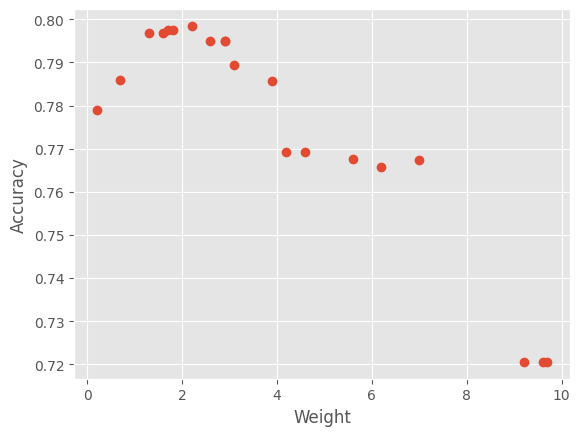

2824


In [105]:

from sklearn.metrics import balanced_accuracy_score
from optuna import create_study

best_mod = MyKNeighborsClassifier(n_neighbors=10, metric=bmods[1]['metric'], kernel=bmods[1]['kernel'])

arr = ([],[])
def check_weight(trial, anomalies):
    w = trial.suggest_float("weight", low=0, high=10,step=0.1)
    wr = [1 for _ in range(len(x_train))]
    for i in anomalies:
        wr[i] = w
    m = MyKNeighborsClassifier(n_neighbors=10, metric=bmods[1]['metric'], kernel=bmods[1]['kernel'], weights=wr)
    m.fit(x_train, y_train)
    arr[0].append(w)
    p = balanced_accuracy_score(y_test, m.predict(x_test))
    arr[1].append(p)
    return p


anom = lowess(best_mod, x_train, y_train)
study = create_study(direction='maximize')
study.optimize(lambda trial: check_weight(trial, anom), n_trials=20)
plt.plot(arr[0],arr[1],'o')
plt.xlabel("Weight")
plt.ylabel("Accuracy")
plt.show()
print(len(anom))

In [93]:
bmods[1]

{'n_neighbors': 1,
 'metric': 'manhattan',
 'kernel': 'uniform_kernel',
 'is_fixed_window': False,
 'window_parameter': 1}